<a href="https://colab.research.google.com/github/owoMarciN/AgileProject/blob/development%2FAG-5-MLP/SmartStreetLighting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install lion-pytorch
!pip install torchvision
!pip install torch_optimizer
!pip install --upgrade ucimlrepo
!pip install optuna
!pip install xgboost
!pip install -U scikit-fuzzy

In [2]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch_optimizer as toptim

In [3]:
# SciKit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

# Dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
import itertools
import random
import optuna
import time

from lion_pytorch import Lion
from torch.utils.data import DataLoader, TensorDataset
from optuna.samplers import TPESampler, NSGAIISampler, GridSampler, RandomSampler
from optuna.pruners import HyperbandPruner

In [5]:
# Ploting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Load data from files
root_dir = '/content/drive/MyDrive/Colab Notebooks/IntroAI/StreetLight/'

In [15]:
df = pd.read_csv(root_dir + "smart_lighting_dataset_2024.csv")

In [16]:
print(df.describe())

           zone_id  ambient_light_lux  motion_detected  temperature_celsius  \
count  12000.00000       12000.000000     12000.000000         12000.000000   
mean       6.53425        3708.629288         0.284083            24.964518   
std        3.48035        4656.283063         0.450996             6.260797   
min        1.00000           0.000000         0.000000           -15.870000   
25%        4.00000          55.565000         0.000000            20.970000   
50%        7.00000        2031.855000         0.000000            24.970000   
75%       10.00000        7011.792500         1.000000            29.082500   
max       12.00000      105403.500000         1.000000            64.860000   

       occupancy_count  special_event_flag  energy_price_per_kwh  \
count     12000.000000        12000.000000          12000.000000   
mean          8.557167            0.008583              5.034449   
std           8.273770            0.092252              1.272504   
min           0.

In [17]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [18]:
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday   # 0 = Monday
df['month'] = df['timestamp'].dt.month
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

In [19]:
# Droping the timestap column after splitting it
df = df.drop(columns=['timestamp'])

# We won't use the binary classification here. We want to predict the energy consumption
df = df.drop(columns=['lighting_action_class'])

# Droping redundat columns
df = df.drop(columns=['day_of_week', 'time_of_day'])

In [20]:
# One-hot encoding which changes a category into a set of independent binary signals.
df = pd.get_dummies(df, columns=['zone_id', 'weather_condition'], drop_first=True)
df

,ambient_light_lux,motion_detected,temperature_celsius,occupancy_count,special_event_flag,energy_price_per_kwh,prev_hour_energy_usage_kwh,traffic_density,avg_pedestrian_speed,adjusted_light_intensity,...,zone_id_6,zone_id_7,zone_id_8,zone_id_9,zone_id_10,zone_id_11,zone_id_12,weather_condition_Cloudy,weather_condition_Foggy,weather_condition_Rainy
0,0.00,0,22.08,7,0,3.83,3.27,26.0,4.54,54.40,...,False,False,False,False,False,False,False,True,False,False
1,35.78,0,19.19,6,0,4.61,1.50,18.9,2.42,89.75,...,False,False,False,False,False,False,False,True,False,False
2,0.00,0,27.78,9,0,4.21,2.51,27.6,2.85,82.25,...,False,True,False,False,False,False,False,False,False,False
3,0.00,1,33.11,16,0,6.16,0.34,23.1,2.45,72.57,...,False,False,False,False,False,False,False,False,True,False
4,0.00,1,27.07,11,0,5.72,1.52,26.4,3.49,78.79,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.00,0,24.84,13,0,4.19,3.96,15.6,4.49,88.85,...,False,False,False,False,False,False,False,False,False,False
11996,170.09,0,20.16,5,0,3.95,2.24,20.5,1.76,89.41,...,False,True,False,False,False,False,False,False,False,False
11997,176.03,0,28.53,8,0,3.02,4.14,35.3,3.53,93.44,...,True,False,False,False,False,False,False,False,False,True
11998,375.50,1,34.16,11,0,3.94,3.82,30.0,2.52,69.08,...,False,False,False,False,False,False,False,False,False,False


---

### Checking the skewness of some of the features. Skewness matters  because many algorithms assume normal (symmetric) distribution, causing skewed data to bias models, distort relationships, increase training time, and make feature importance misleading, requiring transformations (like log transform) to improve performance.

---

In [21]:
# List of skewed features to plot
features = ['ambient_light_lux', 'occupancy_count', 'prev_hour_energy_usage_kwh', 'energy_consumption_kwh']

# Compute skewness
print("Skewness:")
for f in features:
    skew_val = df[f].skew()
    print(f"{f}: {skew_val:.2f}")

Skewness:
ambient_light_lux: 5.72
occupancy_count: 11.76
prev_hour_energy_usage_kwh: 0.43
energy_consumption_kwh: -0.35


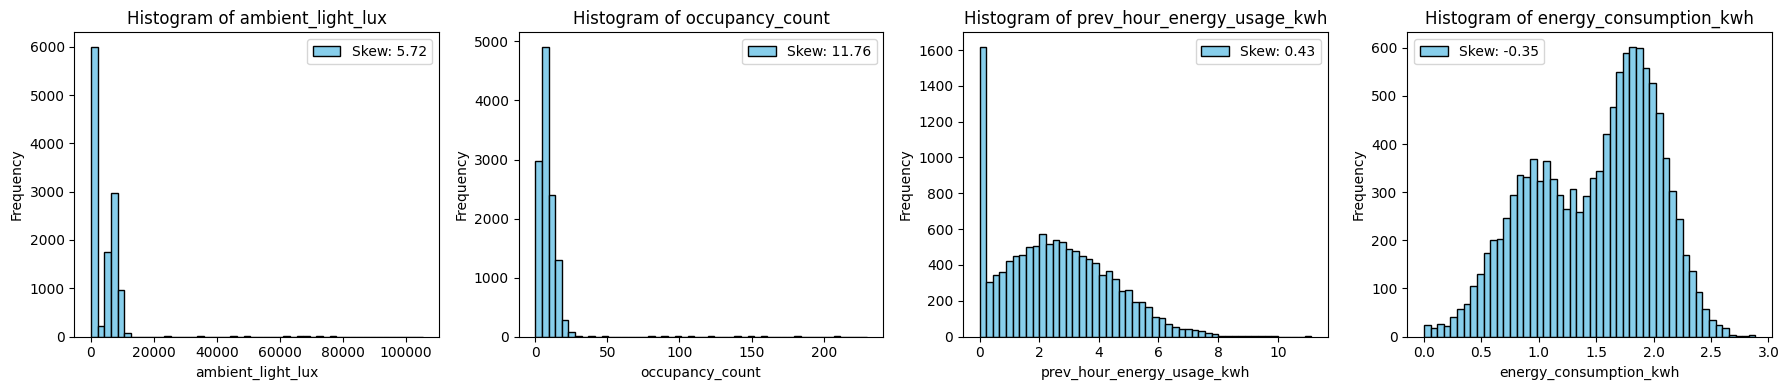

In [23]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(18, 4))

for i, f in enumerate(features):
    skew_val = df[f].skew()
    axes[i].hist(df[f], bins=50, color='skyblue', edgecolor='k', label=f"Skew: {skew_val:.2f}")
    axes[i].set_title(f"Histogram of {f}")
    axes[i].set_xlabel(f)
    axes[i].legend()
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [24]:
# Apply log1p to highly skewed numeric features
df['ambient_light_lux'] = np.log1p(df['ambient_light_lux'])
df['occupancy_count'] = np.log1p(df['occupancy_count'])

In [25]:
target_feature = 'occupancy_count'
X = df.drop(columns=[target_feature])

# Target
y = df[target_feature]

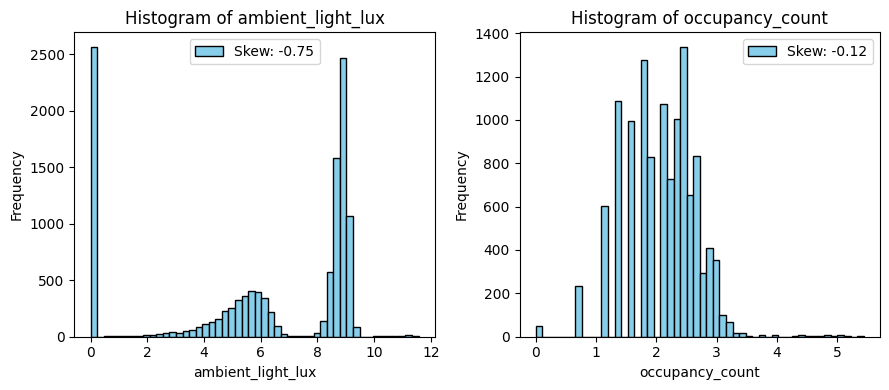

In [33]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(features)-2, figsize=(9, 4))

for i, f in enumerate(features[:2]):
    skew_val = df[f].skew()
    axes[i].hist(df[f], bins=50, color='skyblue', edgecolor='k', label=f"Skew: {skew_val:.2f}")
    axes[i].set_title(f"Histogram of {f}")
    axes[i].set_xlabel(f)
    axes[i].legend()
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------
##Creating a **Pairplot** of the dataset.
--------------------------------------------------------------------------------

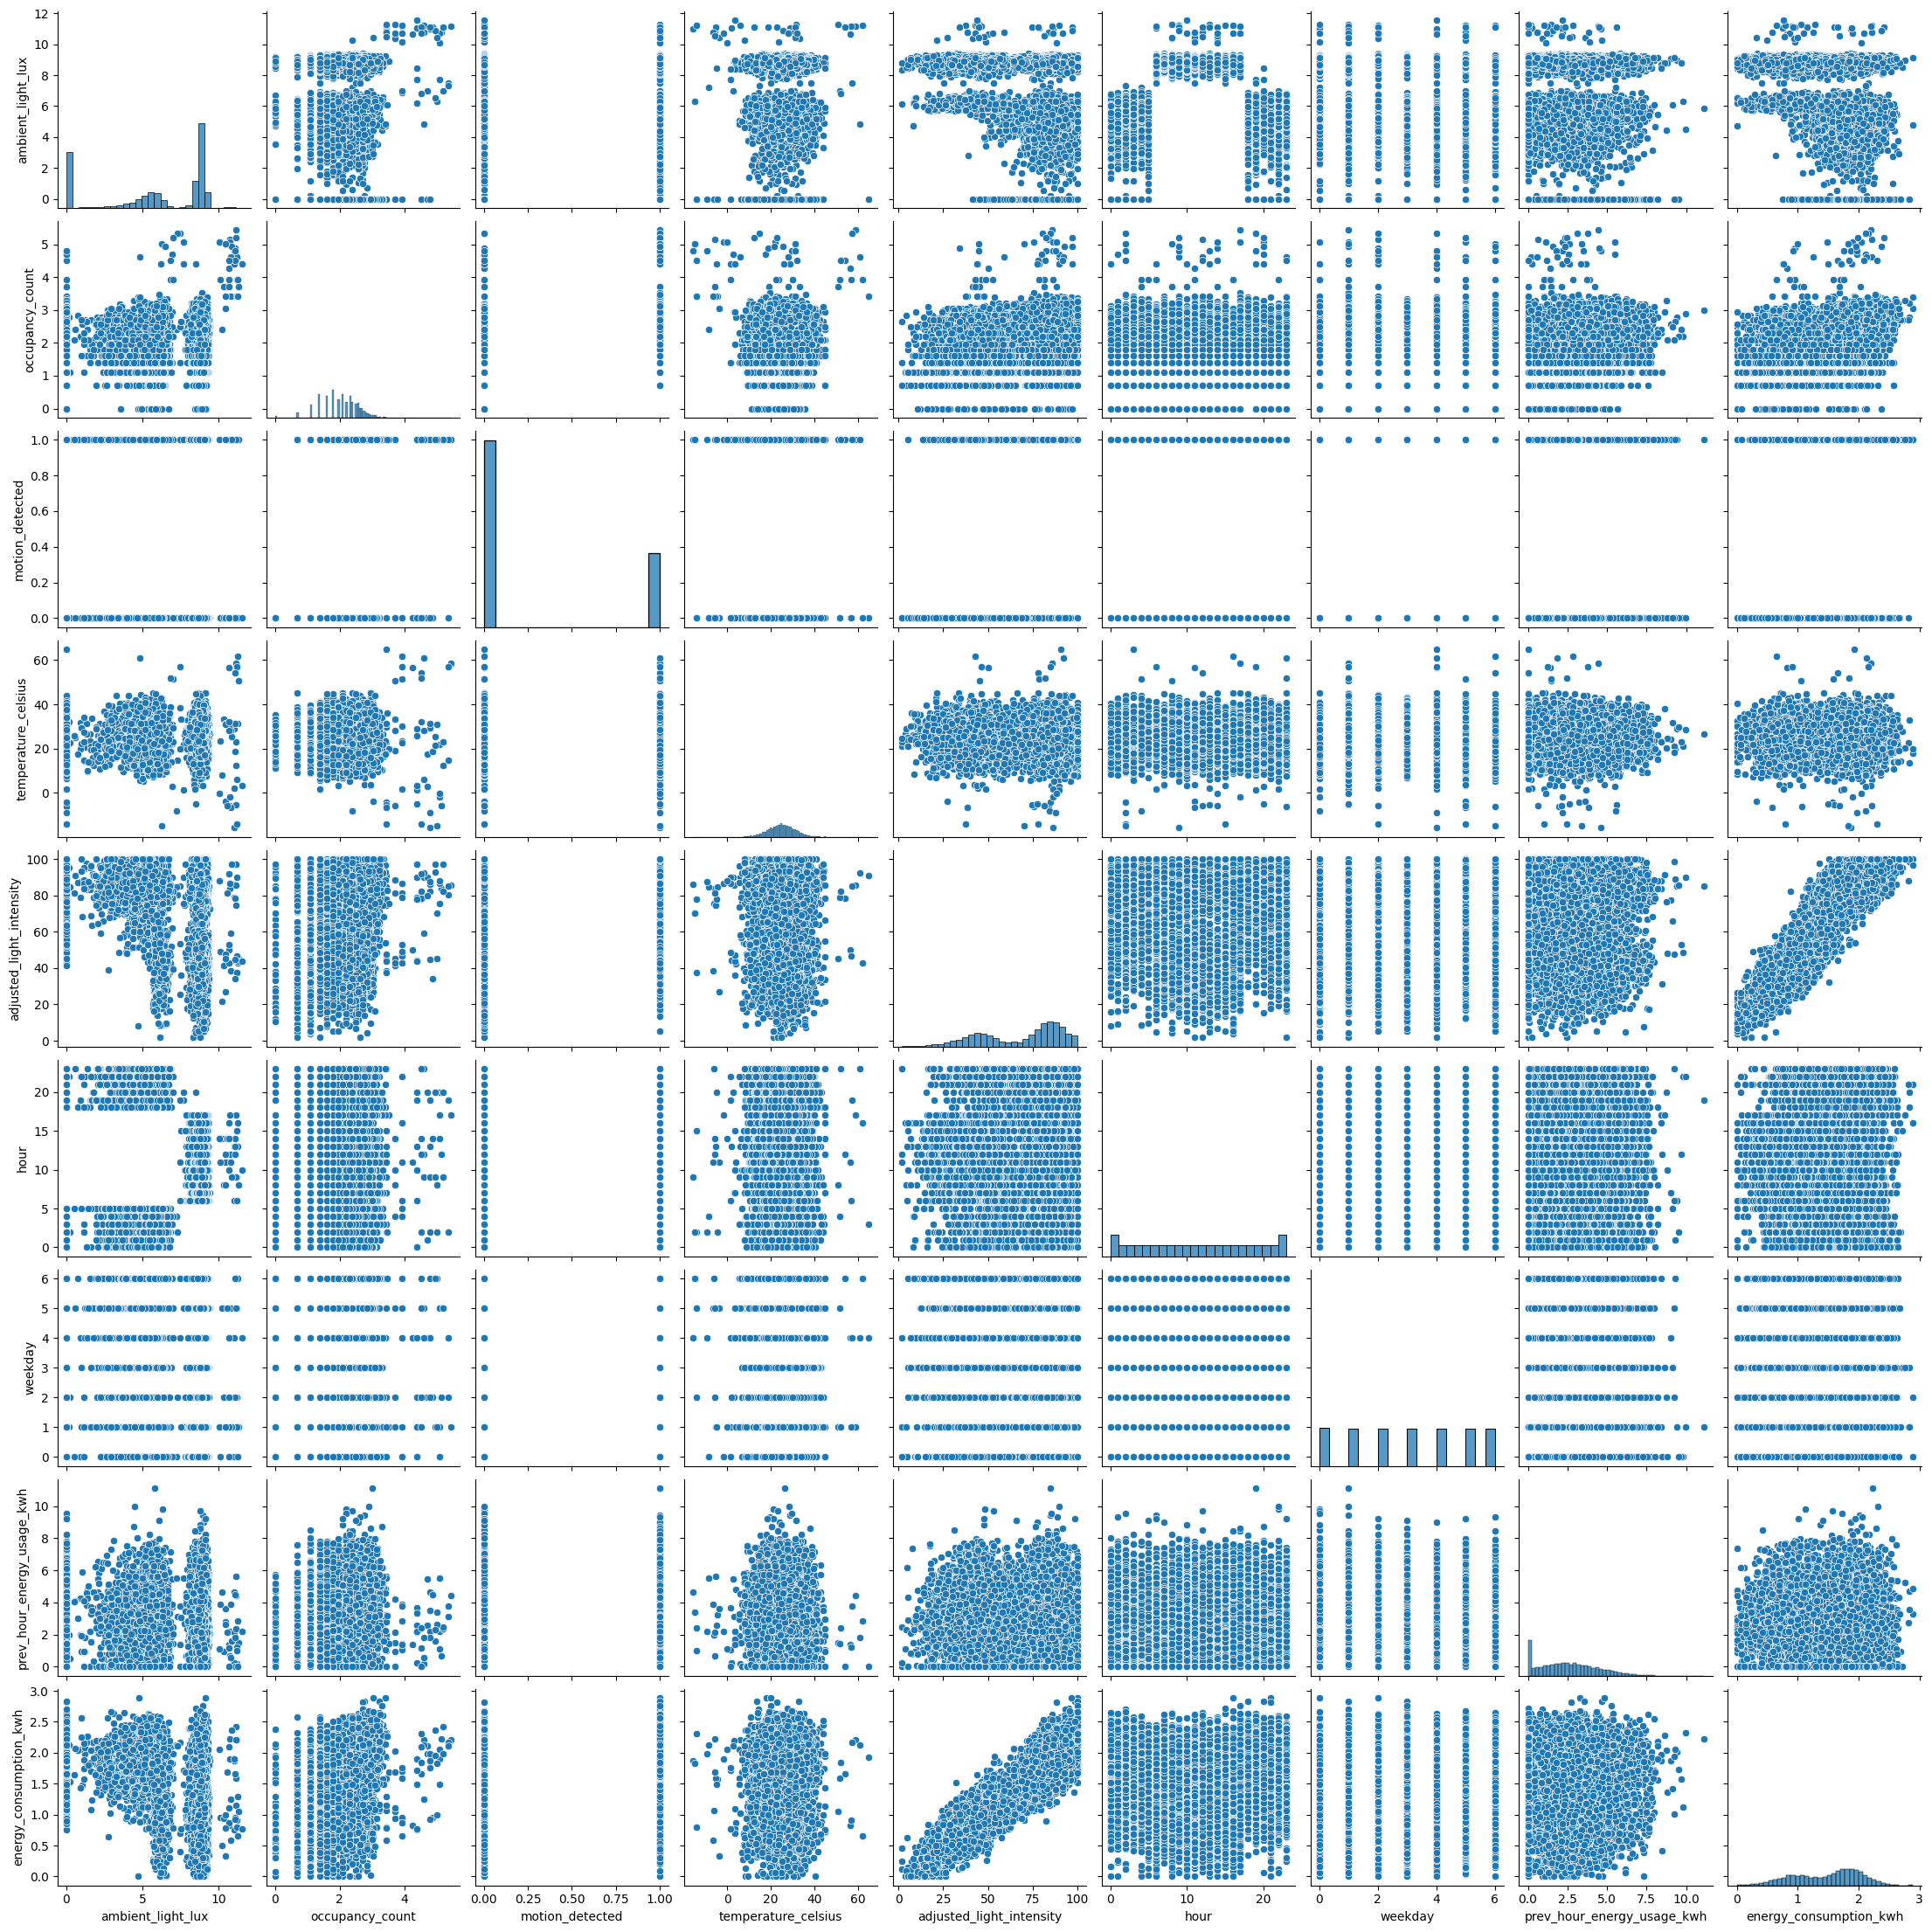

In [34]:
plot_features = [
    'ambient_light_lux',
    'occupancy_count',
    'motion_detected',
    'temperature_celsius',
    'adjusted_light_intensity',
    'hour',
    'weekday',
    'prev_hour_energy_usage_kwh',
    'energy_consumption_kwh'
]

sns.pairplot(df[plot_features])
plt.show()

--------------------------------------------------------------------------------
##Creating a **Correlation HeatMap** of the dataset.
--------------------------------------------------------------------------------

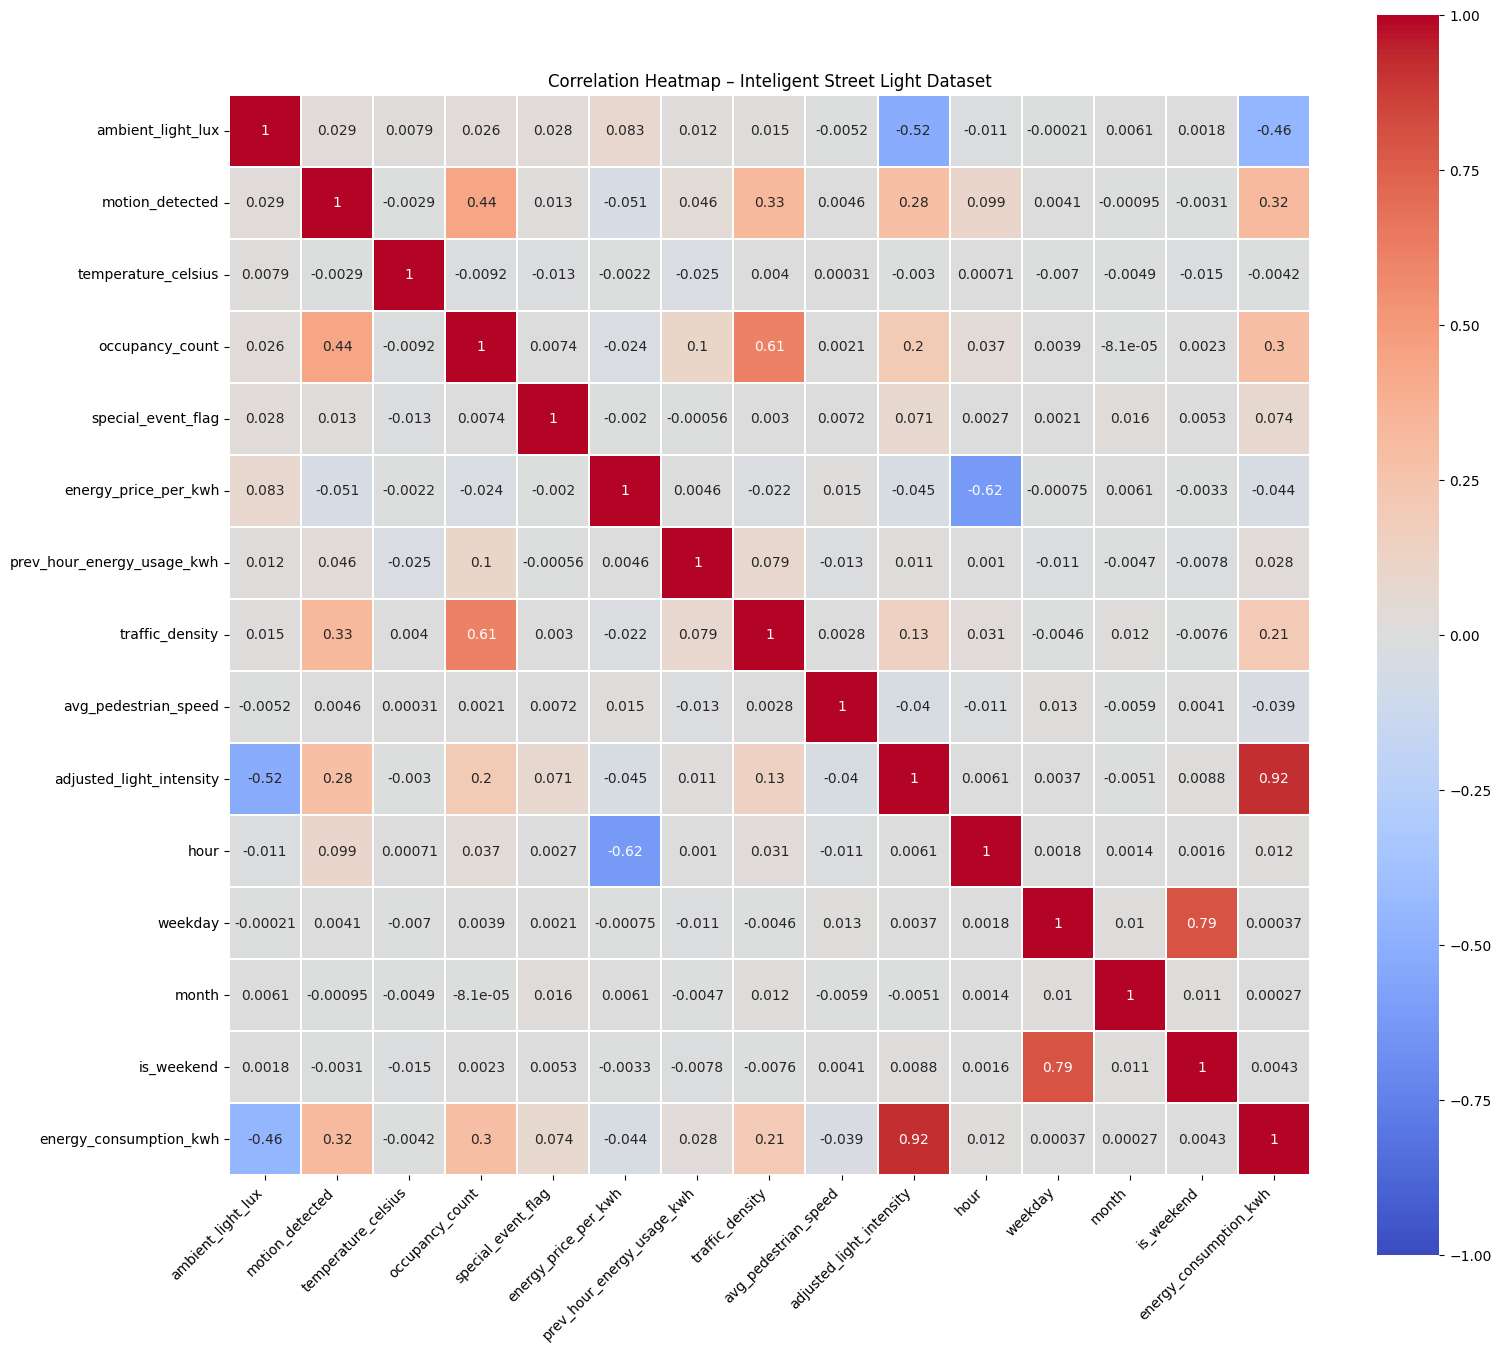

In [35]:
heatmap_features = [
    'ambient_light_lux',
    'motion_detected',
    'temperature_celsius',
    'occupancy_count',
    'special_event_flag',
    'energy_price_per_kwh',
    'prev_hour_energy_usage_kwh',
    'traffic_density',
    'avg_pedestrian_speed',
    'adjusted_light_intensity',
    'hour',
    'weekday',
    'month',
    'is_weekend',
    'energy_consumption_kwh'
]

corr = df[heatmap_features].select_dtypes(include='number').corr(method='pearson')

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.3,
    square=True
)

plt.title("Correlation Heatmap – Inteligent Street Light Dataset")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------
##Creating a **Boxplot** of the normalized data of the dataset.
--------------------------------------------------------------------------------

In [36]:
boxplot_features = X.columns.tolist()
boxplot_features = boxplot_features[0:14]

# Create DataFrame with X features
X_df = pd.DataFrame(X, columns=boxplot_features)

X_df['occupancy_count'] = y.values

In [37]:
# Preprocessing the data by normalizing it
X = StandardScaler().fit_transform(X)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2)

# Ensure all tensors are float32 for consistency with PyTorch models
Xtr, Xte = map(lambda v: torch.tensor(v).float(), (Xtr, Xte))
ytr, yte = map(lambda v: torch.tensor(v.values).float(), (ytr, yte))

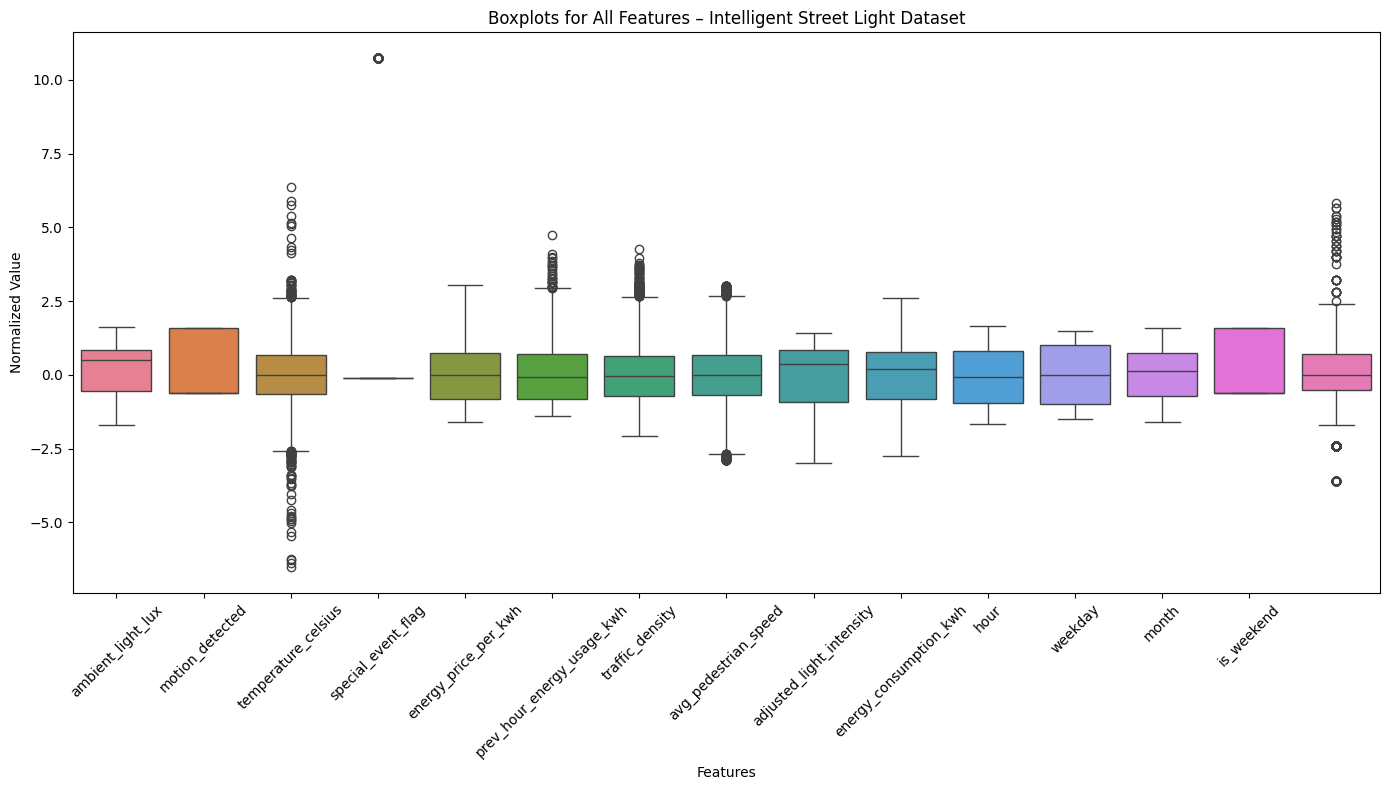

In [38]:
plt.figure(figsize=(14, 8))

X_df = StandardScaler().fit_transform(X_df)
# Create boxplots for all columns in X_df
sns.boxplot(data=X_df)

# Set x-axis ticks and labels
plt.xticks(
    ticks=range(len(boxplot_features)),
    labels=boxplot_features,
    rotation=45
)

# Labels and title
plt.xlabel("Features")
plt.ylabel("Normalized Value")
plt.title("Boxplots for All Features – Intelligent Street Light Dataset")

# Adjust layout and show
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------
##Simple **MLP** implementation with **Hyper-paramenters**
--------------------------------------------------------------------------------

In [57]:
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, in_dim=28, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )
    def forward(self, x):
        z = self.net(x)
        return F.softplus(z)

def get_optimizer(name, params, lr, momentum=0.9, weight_decay=0.0):
    """Return PyTorch optimizer instance based on name."""
    name = name.lower()
    # SGD variants
    if name == "sgd":
        return optim.SGD(params, lr=lr, weight_decay=weight_decay)
    if name == "momentum":
        return optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Adaptive methods
    if name == "adam":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if name == "amsgrad":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay, amsgrad=True)
    if name == "adagrad":
        return optim.Adagrad(params, lr=lr, weight_decay=weight_decay)
    if name == "adadelta":
        return optim.Adadelta(params, lr=lr, weight_decay=weight_decay)

    # Other advanced optimizers (requires torch_optimizer)
    if name == "nadam":
        return optim.NAdam(params, lr=lr, weight_decay=weight_decay)
    if name == "lion":
        return Lion(params, lr=lr, weight_decay=weight_decay)

    # RMSprop
    if name == "rmsprop":
        return optim.RMSprop(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

    raise ValueError(f"Unknown optimizer: {name}")

In [62]:
def train_and_eval(opt_name, Xtr, Xte, ytr, yte, hparams, in_dim=Xtr.shape[1]):
    start_time = time.time()
    model = MLP(in_dim=in_dim, hidden=hparams["hidden_size"])
    optimizer = get_optimizer(opt_name, model.parameters(), lr=hparams["lr"], momentum=hparams["momentum"], weight_decay=hparams["weight_decay"])
    criterion = nn.PoissonNLLLoss(log_input=False)
    losses = []

    train_loader = DataLoader(
        TensorDataset(Xtr, ytr),
        batch_size=hparams["batch_size"],
        shuffle=True
    )

    best_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 10

    for epoch in range(100):
        model.train()
        batch_losses = []

        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb).squeeze()
            loss = criterion(outputs, yb.float())
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        epoch_loss = np.mean(batch_losses)
        losses.append(epoch_loss)

        if early_stop_patience is not None:
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= early_stop_patience:
                # Early stoping if there is no change
                break

        epochs_run = epoch + 1

    model.eval()
    with torch.no_grad():
        y_pred = model(Xte).numpy()

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Regression metrics
    metrics = {
        "RMSE": mean_squared_error(yte, y_pred),
        "MAE": mean_absolute_error(yte, y_pred),
        "R2": r2_score(yte, y_pred),
        "runtime": elapsed_time,
        "epochs": epochs_run
    }

    return metrics, losses

In [63]:
hp = {"lr": 0.01, "momentum": 0.9, "hidden_size": 32, "weight_decay": 0.0, "batch_size": 16}

In [73]:
metrics, losses = train_and_eval("momentum", Xtr, Xte, ytr, yte, hp)
print(f"RMSE:    {metrics['RMSE']:.4f}")
print(f"MAE:     {metrics['MAE']:.4f}")
print(f"R2:      {metrics['R2']:.4f}")
print(f"Runtime: {metrics['runtime']:.4f} sec")

RMSE:    0.1455
MAE:     0.2799
R2:      0.5488
Runtime: 64.5535 sec


In [76]:
import pandas as pd

optimizers = [
    "sgd",
    "momentum",
    "adam",
    "amsgrad",
    "adagrad",
    "adadelta",
    "nadam",
    "lion",
    "rmsprop"
]

results = []

for opt_name in optimizers:
    metrics, losses = train_and_eval(opt_name, Xtr, Xte, ytr, yte, hp)
    results.append({
        "Optimizer": opt_name,
        "RMSE": metrics["RMSE"],
        "MAE": metrics["MAE"],
        "R2": metrics["R2"],
        "Runtime_sec": metrics["runtime"]
    })

df_results = pd.DataFrame(results)

print(df_results)

  Optimizer      RMSE       MAE        R2  Runtime_sec
0       sgd  0.139587  0.275136  0.567103    58.709171
1  momentum  0.143007  0.276643  0.556496    63.523702
2      adam  0.134847  0.272569  0.581803    32.123918
3   amsgrad  0.142238  0.277891  0.558883    76.903755
4   adagrad  0.139659  0.274326  0.566879    65.879926
5  adadelta  0.144537  0.278206  0.551753    74.114802
6     nadam  0.140258  0.277797  0.565022    50.368670
7      lion  0.281344  0.308429  0.127478     8.221233
8   rmsprop  0.226585  0.360257  0.297301    10.164521


In [65]:
def xgb_eval(Xtr, Xte, ytr, yte):
    ytr = ytr.ravel()
    yte = yte.ravel()

    xgb_reg = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        # random_state=42,
    )

    start_time = time.time()
    xgb_reg.fit(Xtr, ytr, verbose=True)
    elapsed_time = time.time() - start_time

    y_pred = xgb_reg.predict(Xte)

    metrics = {
        "RMSE": mean_squared_error(yte, y_pred),
        "MAE": mean_absolute_error(yte, y_pred),
        "R2": r2_score(yte, y_pred),
        "Runtime": elapsed_time
    }
    return metrics

In [47]:
results = {
    "RMSE": [],
    "MAE": [],
    "R2": [],
    "Runtime": []
}

for _ in range(20):
    metrics = xgb_eval(Xtr, Xte, ytr, yte) # choose the model
    results["RMSE"].append(metrics["RMSE"])
    results["MAE"].append(metrics["MAE"])
    results["R2"].append(metrics["R2"])
    results["Runtime"].append(metrics["Runtime"])

print(f"RMSE:    {np.mean(results['RMSE']):.4f} ± {np.std(results['RMSE']):.4f}")
print(f"MAE:     {np.mean(results['MAE']):.4f} ± {np.std(results['MAE']):.4f}")
print(f"R2:      {np.mean(results['R2']):.4f} ± {np.std(results['R2']):.4f}")
print(f"Runtime: {np.mean(results['Runtime']):.4f} ± {np.std(results['Runtime']):.4f} sec")

RMSE:    0.1285 ± 0.0000
MAE:     0.2652 ± 0.0000
R2:      0.6014 ± 0.0000
Runtime: 0.5605 ± 0.1380 sec


--------------------------------------------------------------------------------
#**Dimension Reduction Techniques**
--------------------------------------------------------------------------------

In [66]:
def pca_features(X_train, X_test, var_threshold=0.95):
    # PCA
    pca = PCA(n_components=var_threshold)

    pca.fit(X_train)

    # Transformation train/test
    X_train_pca = pca.transform(X_train).astype("float32")
    X_test_pca = pca.transform(X_test).astype("float32")

    # Number of components
    n_components = pca.n_components_

    return X_train_pca, X_test_pca, n_components

In [67]:
Xtr_pca, Xte_pca, n_components = pca_features(Xtr, Xte, var_threshold=0.95)

Xtr_pca = torch.tensor(Xtr_pca, dtype=torch.float32)
Xte_pca = torch.tensor(Xte_pca, dtype=torch.float32)

metrics, losses = train_and_eval(opt_name="rmsprop", Xtr=Xtr_pca, Xte=Xte_pca, ytr=ytr, yte=yte, hparams=hp, in_dim=n_components)
metrics

{'RMSE': 0.19813545048236847,
 'MAE': 0.34202712774276733,
 'R2': 0.3855292797088623,
 'runtime': 29.47446298599243,
 'epochs': 29}

In [68]:
class SupervisedAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=8):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, bottleneck_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

        self.regressor = nn.Linear(bottleneck_dim, 1)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        y_hat = self.regressor(z)
        return x_hat, y_hat

    def encode(self, x):
        return self.encoder(x)

In [69]:
def autoencoder_features(X_train, X_test, y_train, epochs=300, lr=1e-2, alpha=0.7):
    """alpha: weight for reconstruction loss (1-alpha for regression)"""
    input_dim = X_train.shape[1]
    model = SupervisedAutoencoder(input_dim)

    opt = optim.Adam(model.parameters(), lr=lr)
    recon_loss = nn.SmoothL1Loss()
    reg_loss = nn.SmoothL1Loss()

    model.train()
    for _ in range(epochs):
        opt.zero_grad()
        x, y = model(X_train)
        loss = (
            alpha * recon_loss(x, X_train) +
            (1 - alpha) * reg_loss(y.squeeze(), y_train)
        )
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        Z_train = model.encode(X_train)
        Z_test  = model.encode(X_test)

    return Z_train, Z_test

In [70]:
Xtr_ae, Xte_ae = autoencoder_features(Xtr, Xte, ytr)

metrics, losses = train_and_eval(opt_name="rmsprop", Xtr=Xtr_ae, Xte=Xte_ae, ytr=ytr, yte=yte, hparams=hp, in_dim=8)
metrics

{'RMSE': 0.14662104845046997,
 'MAE': 0.28393876552581787,
 'R2': 0.545289158821106,
 'runtime': 16.08114743232727,
 'epochs': 21}

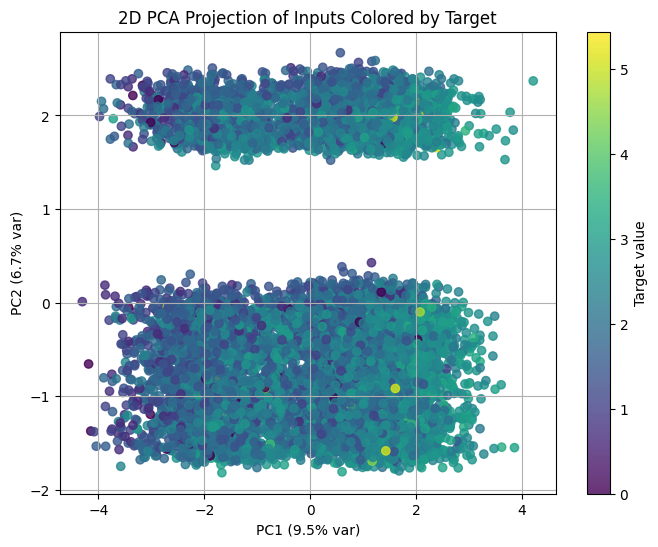

In [71]:
# Ensure NumPy arrays
ytr_np = ytr.numpy().ravel()
Xtr_np = Xtr_pca if isinstance(Xtr_pca, np.ndarray) else Xtr_pca.detach().cpu().numpy()

# PCA to 2D
pca_2d = PCA(n_components=2)
Xtr_pca_2d = pca_2d.fit_transform(Xtr_np)

# Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    Xtr_pca_2d[:, 0],
    Xtr_pca_2d[:, 1],
    c=ytr_np,
    cmap="viridis",
    alpha=0.8
)

plt.colorbar(sc, label="Target value")
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("2D PCA Projection of Inputs Colored by Target")
plt.grid(True)
plt.show()

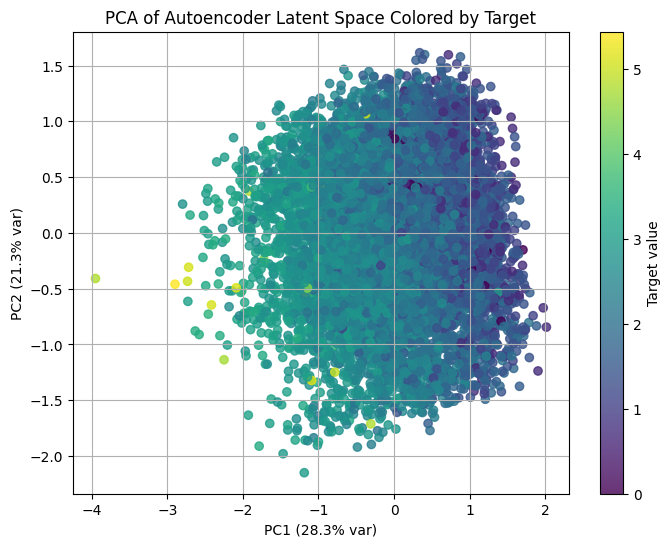

In [72]:
# Ensure NumPy arrays
if isinstance(Xtr_ae, torch.Tensor):
    Xtr_ae_np = Xtr_ae.detach().cpu().numpy()
else:
    Xtr_ae_np = Xtr_ae

ytr_np = ytr.detach().cpu().numpy().ravel() if isinstance(ytr, torch.Tensor) else ytr.ravel()

# PCA to 2D on autoencoder latent space
pca_2d = PCA(n_components=2)
Xtr_ae_pca = pca_2d.fit_transform(Xtr_ae_np)

# Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    Xtr_ae_pca[:, 0],
    Xtr_ae_pca[:, 1],
    c=ytr_np,
    cmap="viridis",
    alpha=0.8
)

plt.colorbar(sc, label="Target value")
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of Autoencoder Latent Space Colored by Target")
plt.grid(True)
plt.show()

--------------------------------------------------------------------------------
#**Hyper-parameter** Analysis
--------------------------------------------------------------------------------

In [33]:
search_space = {
    "lr": [1e-4, 1e-3, 1e-2, 1e-1],
    "momentum": [0.7, 0.8, 0.9, 0.99],
    "hidden_size": [8, 16, 32, 64],
    "weight_decay": [0.001, 0.01],
    "batch_size": [16, 32, 64, 128]
}

In [54]:
def objective(opt_name, Xtr, Xte, ytr, yte, trial):
    hp = {
        "lr": trial.suggest_float("lr", 1e-4, 1e-1, log=True),
        "momentum": trial.suggest_float("momentum", 0.7, 0.99),
        "hidden_size": trial.suggest_categorical("hidden_size", [8, 16, 32, 64]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64,])
    }

    metrics, losses = train_and_eval(opt_name, Xtr, Xte, ytr, yte, hp)
    trial.set_user_attr("losses", losses)
    trial.set_user_attr("optimizer", opt_name)
    trial.set_user_attr("metrics", metrics)
    return metrics["RMSE"]

In [55]:
# Optuna Grid Search
def run_optuna_grid_search(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="minimize",
        sampler=GridSampler(search_space=search_space)
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_losses, best_metrics

In [56]:
# Optuna Random Search
def run_optuna_random_search(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="minimize",
        sampler=RandomSampler()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    best_trial = study.best_trial
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_losses, best_metrics

In [57]:
# Bayesian Optimization
def run_bayesian_optimization(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="minimize",
        sampler=TPESampler()
    )
    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    best_trial = study.best_trial
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_losses, best_metrics

In [58]:
# Hyperband / BOHB — Adaptive resource allocation.
def run_hyperband(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="minimize",
        pruner=HyperbandPruner()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    best_trial = study.best_trial
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_losses, best_metrics

In [38]:
# Evolutionary / Metaheuristic Search — GA, PSO, DE for AutoML.
def run_evolutionary(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="minimize",
        sampler=NSGAIISampler()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    best_trial = study.best_trial
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_losses, best_metrics

In [ ]:
results = {}

# As for now testing the baseline with 'Adam' optimizer
adam_opt = "rmsprop"

# Baselines
grid_hp, grid_rmse, grid_traj, grid_loss, grid_met = run_optuna_grid_search(opt_name=adam_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

results["Grid"] = grid_hp
results["Grid_rmse"] = grid_rmse
results["Grid_traj"] = grid_traj
results["Grid_loss"] = grid_loss
results["Grid_met"] = grid_met

rand_hp, rand_rmse, rand_traj, rand_loss, rand_met = run_optuna_random_search(opt_name=adam_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

results["Random"] = rand_hp
results["Random_rmse"] = rand_rmse
results["Random_traj"] = rand_traj
results["Random_loss"] = rand_loss
results["Random_met"] = rand_met

# Advanced methods
bo_hp, bo_rmse, bo_traj, bo_loss, bo_met = run_bayesian_optimization(opt_name=adam_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

results["Bayes"] = bo_hp
results["Bayes_rmse"] = bo_rmse
results["Bayes_traj"] = bo_traj
results["Bayes_loss"] = bo_loss
results["Bayes_met"] = bo_met

hb_hp, hb_rmse, hb_traj, hb_loss, hb_met = run_hyperband(opt_name=adam_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

results["Hyperband"] = hb_hp
results["Hyperband_rmse"] = hb_rmse
results["Hyperband_traj"] = hb_traj
results["Hyperband_loss"] = hb_loss
results["Hyperband_met"] = hb_met

ev_hp, ev_rmse, ev_traj, ev_loss, ev_met = run_evolutionary(opt_name=adam_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

results["Evolutionary"] = ev_hp
results["Evolutionary_rmse"] = ev_rmse
results["Evolutionary_traj"] = ev_traj
results["Evolutionary_loss"] = ev_loss
results["Evolutionary_met"] = ev_met

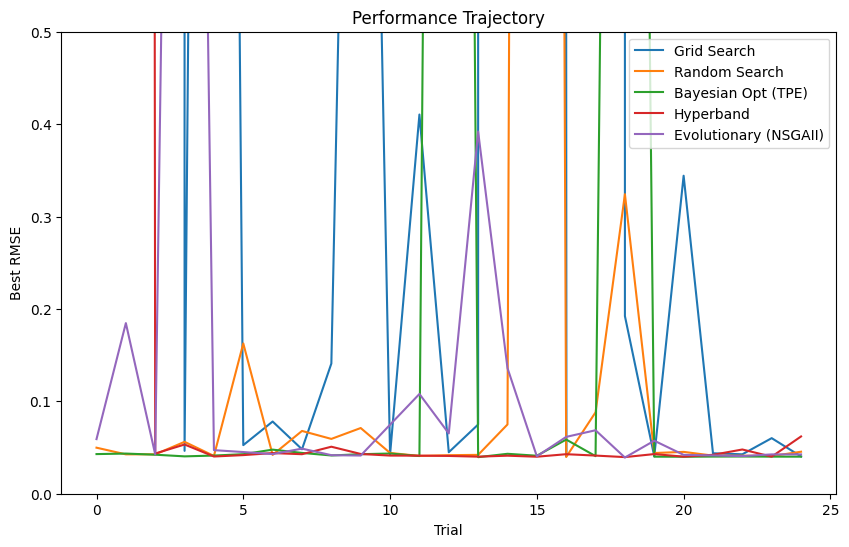

In [49]:
# ------------------------------------------------------------------------------
# Truncate trajectories and performances for consistent plotting, as Optuna
# Grid Search runs all combinations while other methods are limited by
# n_trials (defaulting to 25).
# ------------------------------------------------------------------------------

N_TRIALS = 25

plt.figure(figsize=(10, 6))
plt.plot(results["Grid_traj"][:N_TRIALS], label="Grid Search")
plt.plot(results["Random_traj"][:N_TRIALS], label="Random Search")
plt.plot(results["Bayes_traj"][:N_TRIALS], label="Bayesian Opt (TPE)")
plt.plot(results["Hyperband_traj"][:N_TRIALS], label="Hyperband")
plt.plot(results["Evolutionary_traj"][:N_TRIALS], label="Evolutionary (NSGAII)")

plt.ylim([0, 0.5])
plt.xlabel("Trial")
plt.ylabel("Best RMSE")
plt.title("Performance Trajectory")
plt.legend()
plt.show()

# ------------------------------------------------------------------------------
# Changes to the evaluation class must be made if you want the 'elapsed_time'
# trajectories.
# For now 'grid_perf' returns only the best trial performance time.
# ------------------------------------------------------------------------------

# plt.figure(figsize=(10, 6))
# plt.plot(results["Grid_perf"][:N_TRIALS], label="Grid Search")
# plt.plot(results["Random_perf"][:N_TRIALS], label="Random Search")
# plt.plot(results["Bayes_perf"][:N_TRIALS], label="Bayesian Opt (TPE)")
# plt.plot(results["Hyperband_perf"][:N_TRIALS], label="Hyperband")
# plt.plot(results["Evolutionary_perf"][:N_TRIALS], label="Evolutionary (NSGAII)")

# plt.xlabel("Trial")
# plt.ylabel("Elapsed Time (s)")
# plt.title("Elapsed Time per Trial")
# plt.legend()
# plt.show()

In [43]:
table = pd.DataFrame({
    "Method": ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"],
    "Best RMSE": [results["Grid_met"]["RMSE"], results["Random_met"]["RMSE"], results["Bayes_met"]["RMSE"], results["Hyperband_met"]["RMSE"], results["Evolutionary_met"]["RMSE"]],
    "MAE": [results["Grid_met"]["MAE"], results["Random_met"]["MAE"], results["Bayes_met"]["MAE"], results["Hyperband_met"]["MAE"], results["Evolutionary_met"]["MAE"]],
    "R2": [results["Grid_met"]["R2"], results["Random_met"]["R2"], results["Bayes_met"]["R2"], results["Hyperband_met"]["R2"], results["Evolutionary_met"]["R2"]],
    "Epochs":  [results["Grid_met"]["epochs"], results["Random_met"]["epochs"], results["Bayes_met"]["epochs"], results["Hyperband_met"]["epochs"], results["Evolutionary_met"]["epochs"]],
    "RunTime": [results["Grid_met"]["runtime"], results["Random_met"]["runtime"], results["Bayes_met"]["runtime"], results["Hyperband_met"]["runtime"], results["Evolutionary_met"]["runtime"]],
    "Best Params": [
        results["Grid"], results["Random"], results["Bayes"], results["Hyperband"], results["Evolutionary"]
    ]
})

print(table)
table.to_latex(index=False)

         Method  Best RMSE       MAE        R2  Epochs    RunTime  \
0          Grid   0.040346  0.160635  0.853350      36  15.244595   
1        Random   0.039784  0.158941  0.855393     100  75.654547   
2         Bayes   0.039568  0.158654  0.856176      96  67.815706   
3     Hyperband   0.039630  0.159321  0.855951      73  30.574966   
4  Evolutionary   0.039169  0.158140  0.857628     100  24.375950   

                                         Best Params  
0  {'lr': 0.001, 'momentum': 0.8, 'hidden_size': ...  
1  {'lr': 0.00011336203594147356, 'momentum': 0.8...  
2  {'lr': 0.0001001199194689484, 'momentum': 0.78...  
3  {'lr': 0.00011758338835518428, 'momentum': 0.7...  
4  {'lr': 0.00010099809846925246, 'momentum': 0.7...  


"\\begin{tabular}{lrrrrrl}\n\\toprule\nMethod & Best RMSE & MAE & R2 & Epochs & RunTime & Best Params \\\\\n\\midrule\nGrid & 0.040346 & 0.160635 & 0.853350 & 36 & 15.244595 & {'lr': 0.001, 'momentum': 0.8, 'hidden_size': 8, 'weight_decay': 0.001, 'batch_size': 32} \\\\\nRandom & 0.039784 & 0.158941 & 0.855393 & 100 & 75.654547 & {'lr': 0.00011336203594147356, 'momentum': 0.8459333961566982, 'hidden_size': 8, 'weight_decay': 2.7701066684272902e-05, 'batch_size': 32} \\\\\nBayes & 0.039568 & 0.158654 & 0.856176 & 96 & 67.815706 & {'lr': 0.0001001199194689484, 'momentum': 0.7812601680504824, 'hidden_size': 8, 'weight_decay': 0.0005296999109306517, 'batch_size': 16} \\\\\nHyperband & 0.039630 & 0.159321 & 0.855951 & 73 & 30.574966 & {'lr': 0.00011758338835518428, 'momentum': 0.7944986157936896, 'hidden_size': 8, 'weight_decay': 8.995406694291151e-05, 'batch_size': 32} \\\\\nEvolutionary & 0.039169 & 0.158140 & 0.857628 & 100 & 24.375950 & {'lr': 0.00010099809846925246, 'momentum': 0.76410

--------------------------------------------------------------------------------
#**Everything together** - Reduction Techniques $\times$ Optimizers $\times$ Hyper-parameters
--------------------------------------------------------------------------------


In [68]:
from tqdm import tqdm

results = {}

opt = [
    "sgd",
    "momentum",
    "adam",
    "amsgrad",
    "adagrad",
    "adadelta",
    "nadam",
    "lion",
    "rmsprop"
]

features = {
    "raw": (Xtr, Xte),
    "pca": pca_features(Xtr, Xte, var_threshold=0.95)[:2],
    "autoencoder": autoencoder_features(Xtr, Xte, epochs=1000, lr=1e-2)
}

def to_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.detach().clone().float()
    elif isinstance(x, np.ndarray):
        return torch.from_numpy(x).float()
    else:
        raise TypeError(f"Unsupported type: {type(x)}")

# Convert all features safely
for key, (Xtr_feat, Xte_feat) in features.items():
    features[key] = (
        to_tensor(Xtr_feat),
        to_tensor(Xte_feat)
    )

total_steps = len(features) * len(opt)

with tqdm(total=total_steps, desc="Running experiments") as pbar:

    for feat_name, (Xtr_feat, Xte_feat) in features.items():
        results[feat_name] = {}

        for opt_name in opt:
            results[feat_name][opt_name] = {}  # Create sub-dict for each optimizer

            # Baselines
            grid_hp, grid_rmse, grid_traj, grid_loss, grid_met = run_optuna_grid_search(opt_name=adam_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

            results["Grid"] = grid_hp
            results["Grid_rmse"] = grid_rmse
            results["Grid_traj"] = grid_traj
            results["Grid_loss"] = grid_loss
            results["Grid_met"] = grid_met

            rand_hp, rand_rmse, rand_traj, rand_loss, rand_met = run_optuna_random_search(opt_name=adam_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

            results["Random"] = rand_hp
            results["Random_rmse"] = rand_rmse
            results["Random_traj"] = rand_traj
            results["Random_loss"] = rand_loss
            results["Random_met"] = rand_met

            # Advanced methods
            bo_hp, bo_rmse, bo_traj, bo_loss, bo_met = run_bayesian_optimization(opt_name=adam_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

            results["Bayes"] = bo_hp
            results["Bayes_rmse"] = bo_rmse
            results["Bayes_traj"] = bo_traj
            results["Bayes_loss"] = bo_loss
            results["Bayes_met"] = bo_met

            hb_hp, hb_rmse, hb_traj, hb_loss, hb_met = run_hyperband(opt_name=adam_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

            results["Hyperband"] = hb_hp
            results["Hyperband_rmse"] = hb_rmse
            results["Hyperband_traj"] = hb_traj
            results["Hyperband_loss"] = hb_loss
            results["Hyperband_met"] = hb_met

            ev_hp, ev_rmse, ev_traj, ev_loss, ev_met = run_evolutionary(opt_name=adam_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

            results["Evolutionary"] = ev_hp
            results["Evolutionary_rmse"] = ev_rmse
            results["Evolutionary_traj"] = ev_traj
            results["Evolutionary_loss"] = ev_loss
            results["Evolutionary_met"] = ev_met

            pbar.update(1)

Running experiments:   0%|          | 0/36 [00:00<?, ?it/s][I 2025-12-21 18:45:48,480] A new study created in memory with name: no-name-06dda1b9-bed1-41d3-b8fc-f00a9a31d91a
[I 2025-12-21 18:46:02,776] Trial 0 finished with value: 28.838397979736328 and parameters: {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 16, 'weight_decay': 0.01, 'batch_size': 16}. Best is trial 0 with value: 28.838397979736328.
[I 2025-12-21 18:46:12,074] Trial 1 finished with value: 61.61167907714844 and parameters: {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 32}. Best is trial 0 with value: 28.838397979736328.
[I 2025-12-21 18:46:24,142] Trial 2 finished with value: 89.19902038574219 and parameters: {'lr': 0.1, 'momentum': 0.9, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 16}. Best is trial 0 with value: 28.838397979736328.
[I 2025-12-21 18:46:34,855] Trial 3 finished with value: 0.046058520674705505 and parameters: {'lr': 0.01, 'momentum': 0.7, 'hidden_size

KeyboardInterrupt: 

In [ ]:
features = ["raw", "kmeans", "pca", "autoencoder"]
optimizers = [
    "sgd",
    "momentum",
    "adam",
    "amsgrad",
    "adagrad",
    "adadelta",
    "nadam",
    "lion",
    "rmsprop"
]

hp_algos = ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"]
algos = ["Grid", "Random", "TPE", "Hyperband", "NSGAII"]

for feat in features:
    plt.figure(figsize=(16,10))
    for opt in optimizers:
        for i in range(len(hp_algos)):
            loss_curve = results[feat][opt][hp_algos[i] + "_loss"]
            label_name = f"{opt}+{algos[i]}"
            plt.plot(loss_curve, label=label_name)

    plt.ylim([0, 1])
    plt.title(f"Loss Curves per Epoch (Best Trial) for {feat.upper()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(fontsize=6, ncol=3)
    plt.grid(True)
    plt.show()

In [ ]:
def compact_params(hp_dict):
    # Convert long dict to short string, rounding floats
    if hp_dict is None:
        return ""
    return ", ".join(f"{k}={round(v, 4) if isinstance(v, float) else v}" for k, v in hp_dict.items())

rows = []

for feat_name, feat_dict in results.items():
    for opt_name, opt_dict in feat_dict.items():
        for algo in ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"]:
          time = opt_dict.get(f"{algo}_perf", None)
          met = opt_dict.get(f"{algo}_met", None)
          best_hp = opt_dict.get(algo, None)
          if met is not None:
              rows.append({
                  "Feature": feat_name,
                  "Optimizer": opt_name,
                  "HP Algorithm": algo,
                  "Accuracy": round(met.get("acc", 0), 4),
                  "Precision": round(met.get("prec", 0), 4),
                  "Recall": round(met.get("rec", 0), 4),
                  "F1": round(met.get("f1", 0), 4),
                  "AUC": round(met.get("auc", 0), 4),
                  "Epochs": met.get("epochs", 0),
                  "Run-Time": round(time, 4),
                  "Best Params": compact_params(best_hp)
                })

table_clean = pd.DataFrame(rows)

# Export to LaTeX
latex_code = table_clean.to_latex(index=False, longtable=True)
print(latex_code)

--------------------------------------------------------------------------------
#Best performing model + Hybrid (Fuzzy Rules and Bayesian)
## **PCA + RMSprop + Hyperband + Hybrid**
--------------------------------------------------------------------------------

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch Tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.values).float().ravel() # Extract values and flatten before converting to tensor

# Split data
Xtr, Xte, ytr, yte = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
Xtr_pca, Xte_pca, n_components = pca_features(Xtr, Xte, var_threshold=0.95)

Xtr_pca_tensor = torch.from_numpy(Xtr_pca).float()
Xte_pca_tensor = torch.from_numpy(Xte_pca).float()

Xtr_ae, Xte_ae = autoencoder_features(Xtr, Xte, epochs=100, lr=1e-3)

In [ ]:
import skfuzzy as fuzz

def fuzzy_score(X, alpha1=0.5, beta1=0.5, alpha2=0.5, beta2=1.5, rho=2.0):
    """
    Compute fuzzy membership scores for selected features.
    The example features (0 and 5) correspond to 'MDVP:Fo(Hz)' and 'MDVP:Shimmer'
    in the Parkinson's dataset (after dropping 'name' and 'status').
    """
    X_np = X.numpy()
    f1 = X_np[:, 0]  # MDVP:Fo(Hz) - mean fundamental frequency
    f2 = X_np[:, 5]  # MDVP:Shimmer - local shimmer variability

    # Simplified High-Risk Membership for scaled data (~1 to 2 standard deviations above mean)
    mu_high_f1 = 1 / (1 + np.exp(-alpha1 * (f1 - beta1))) # Higher f1 -> higher membership
    mu_high_f2 = 1 / (1 + np.exp(-alpha2 * (f2 - beta2))) # Higher f2 -> higher membership

    # Weighted sum as fuzzy score (Higher R implies higher risk)
    R = rho * mu_high_f1 + (1.0 - rho) * mu_high_f2

    # Ensure R is between 0 and 1
    R = np.clip(R, 0, 1)
    return torch.tensor(R, dtype=torch.float32)


# ------------------------------
# 4. Rule-Based Overrides
# ------------------------------
def rule_override(p, X, k=1.0, base=0.7, scale=0.3):
    """
    Soft rule-based override for probabilities based on critical feature patterns.
    Instead of hard 0.9, use a sigmoidal scaling based on extremeness of features.

    Parameters:
        p (torch.Tensor): Original probabilities (batch_size,)
        X (torch.Tensor): Input features (batch_size, n_features)
        k (float): Sigmoid slope controlling how fast p approaches max
        base (float): Base probability for borderline cases
        scale (float): Maximum additional probability added for extreme cases
    Returns:
        torch.Tensor: Updated probabilities
    """
    p_new = p.clone()

    # Critical features
    f1 = X[:, 0]  # MDVP:Fo(Hz)
    f2 = X[:, 16] # HNR

    # Calculate "extremeness" as sum of standardized deviations below -1
    extremeness = torch.clamp((-f1 - 1) + (-f2 - 1), min=0)

    # Apply sigmoid to map extremeness to [0,1]
    adjustment = scale * torch.sigmoid(k * extremeness)

    # Apply soft override
    critical_mask = (f1 < -1) & (f2 < -1)
    p_new[critical_mask] = torch.clamp(base + adjustment[critical_mask], max=1.0)

    return p_new


# ------------------------------
# 5. Bayesian Posterior Update
# ------------------------------
def bayesian_update(p_likelihood, prior=0.7):
    """
    Compute posterior probability using Bayes theorem (P(D|E)).
    D = Disease (Parkinson's), E = Evidence (Hybrid MLP/Fuzzy Score)
    p_likelihood is P(E|D) if we assume the score represents the likelihood of the evidence E
    given the disease D, but in classification, it's usually P(D|E).

    The formula used in the code is for P(D|E) where E is the likelihood score itself:
    P(D|E) = (P(E|D) * P(D)) / (P(E|D)*P(D) + P(E|~D)*P(~D))"""

    P_E_given_D = p_likelihood # Simplified
    P_E_given_notD = 1 - p_likelihood # Simplified

    # Prior probability of having the condition (Parkinson's) - P(D)
    P_D = prior
    # Prior probability of not having the condition - P(~D)
    P_notD = 1 - prior

    # Bayes' Theorem for Posterior P(D|E)
    numerator = P_E_given_D * P_D
    denominator = numerator + P_E_given_notD * P_notD + 1e-8

    posterior = numerator / denominator
    return posterior

# ------------------------------
# 6. Train & Evaluate Hybrid MLP
# ------------------------------
def train_and_eval_hybrid(opt_name, Xtr, Xte, Xtr_orig, Xte_orig, ytr, yte, is_hybrid, hparams, in_dim=Xtr.shape[1]):
    start_time = time.time()

    # Ensure yte is integer for metrics where needed
    yte_int = yte.int().numpy()

    model = MLP(in_dim=in_dim, hidden=hparams["hidden_size"])
    optimizer = get_optimizer(opt_name, model.parameters(), lr=hparams["lr"], momentum=hparams["momentum"], weight_decay=hparams["weight_decay"])
    criterion = nn.BCELoss() # Binary Cross Entropy Loss

    train_loader = DataLoader(
        TensorDataset(Xtr, ytr),
        batch_size=hparams["batch_size"],
        shuffle=True
    )

    for epoch in range(hparams["epochs"]):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb).squeeze()
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

    # ---------- Hybrid Reasoning Layer ----------
    model.eval()
    with torch.no_grad():
        # Base MLP probability
        p = model(Xte).squeeze()  # P_MLP
        p_current = p

        # Step 11: Fuzzy scoring
        if is_hybrid[0]:
            R = fuzzy_score(
                Xte_orig,
                hparams["alpha1"], hparams["beta1"],
                hparams["alpha2"], hparams["beta2"],
                hparams["rho"]
            )
            p_current = hparams["mlp_weight"] * p_current + (1.0 - hparams["mlp_weight"]) * R

        # Step 12: Rule-based override
        if is_hybrid[1]:
            p_current = rule_override(
                p_current,
                Xte_orig,
                hparams["k"],
                hparams["base"],
                hparams["scale"]
            )

        # Step 13: Bayesian update
        if is_hybrid[2]:
            p_current = bayesian_update(p_current, prior=hparams["prior"])

    # Final prediction
    y_pred = (p_current >= 0.5).int().numpy()

    end_time = time.time()
    duration = end_time - start_time

    metrics = {
            "acc": accuracy_score(yte_int, y_pred),
            "prec": precision_score(yte_int, y_pred, zero_division=0),
            "rec": recall_score(yte_int, y_pred, zero_division=0),
            "f1": f1_score(yte_int, y_pred, zero_division=0),
            "auc": roc_auc_score(yte_int, p_current.numpy()), # Use p_current for AUC as it's the final probability
            "mcc": matthews_corrcoef(yte_int, y_pred),
            "time": duration
        }

    return metrics

In [ ]:
def objective_hybrid(opt_name, Xtr, Xte, Xtr_or, Xte_or, ytr, yte, is_hybrid, in_dim, trial):
    hp = {
        "lr": trial.suggest_float("lr", 1e-4, 1e-1, log=True),
        "momentum": trial.suggest_float("momentum", 0.7, 0.99),
        "hidden_size": trial.suggest_categorical("hidden_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
        "mlp_weight": trial.suggest_float("mlp_weight", 0.1, 0.9),
        "alpha1": trial.suggest_int("alpha1", 1, 10),
        "beta1": trial.suggest_float("beta1", 0.5, 2.0),
        "alpha2": trial.suggest_int("alpha2", 1, 10),
        "beta2": trial.suggest_float("beta2", 0.5, 2.0),
        "rho": trial.suggest_float("rho", 0.01, 1.0),
        "prior": ytr.float().mean().item(),
        "k": trial.suggest_float("k", 0.5, 5.0),
        "base": trial.suggest_float("base", 0.01, 1.0),
        "scale": trial.suggest_float("scale", 0.01, 1.0),
        "epochs": 100
    }

    metrics = train_and_eval_hybrid(opt_name, Xtr, Xte, Xtr_or, Xte_or, ytr, yte, is_hybrid, hp, in_dim)

    trial.set_user_attr("metrics", metrics)
    trial.set_user_attr("elapsed_time", metrics["time"])

    return metrics["f1"]

In [ ]:
study_hybrid = optuna.create_study(
        direction="maximize",
        pruner=HyperbandPruner()
    )

results = {
    "acc" : [],
    "prec" : [],
    "rec" : [],
    "f1" : [],
    "auc" : [],
    "mcc" : [],
    "time" : []
}

is_hybrid = [True, True, True]
for _ in range(5):
    study_hybrid.optimize(lambda trial: objective_hybrid("rmsprop", Xtr_pca_tensor, Xte_pca_tensor, Xtr, Xte, ytr, yte, is_hybrid, n_components, trial), n_trials=10) # Fuzzy, Rule, Bayesian
    # study_hybrid.optimize(lambda trial: objective_hybrid("adam", Xtr, Xte, Xtr, Xte, ytr, yte, is_hybrid, Xtr.shape[1], trial), n_trials=10)
    #study_hybrid.optimize(lambda trial: objective_hybrid("RMSprop", Xtr_ae, Xte_ae, Xtr, Xte, ytr, yte, is_hybrid, 8, trial), n_trials=10)

    print("Number of finished trials: ", len(study_hybrid.trials))
    print("Best trial:")

    trial_hybrid = study_hybrid.best_trial

    print("  Value (F1): ", trial_hybrid.value)
    print("  Params: ")
    for key, value in trial_hybrid.params.items():
        print(f"    {key}: {value}")

    print("  Metrics (Best Trial):")
    best_hybrid_metrics = trial_hybrid.user_attrs['metrics']
    for key, value in best_hybrid_metrics.items():
        results[key].append(value)
        print(f"    {key}: {value}")

In [ ]:
print(f"{np.mean(results["acc"]):.4f}, {np.std(results["acc"]):.4f}")
print(f"{np.mean(results["prec"]):.4f}, {np.std(results["prec"]):.4f}")
print(f"{np.mean(results["rec"]):.4f}, {np.std(results["rec"]):.4f}")
print(f"{np.mean(results["f1"]):.4f}, {np.std(results["f1"]):.4f}")
print(f"{np.mean(results["auc"]):.4f}, {np.std(results["auc"]):.4f}")
print(f"{np.mean(results["mcc"]):.4f}, {np.std(results["mcc"]):.4f}")